In [1]:
import pandas as pd
import numpy as np
import datetime
from dateutil import relativedelta
import matplotlib.pyplot as plt
from scipy.stats import genpareto, norm
import math
from scipy.stats import chi2
from functools import partial

In [2]:
np.warnings.filterwarnings('ignore')

# Objective

The main objective of this notebook is to know the modified value at risk, or called Cornish-Fisher value at risk too, because it use the Cornish-Fisher expansion to calculate a $Z$ modified by skewness and kurtosis. Beside it, this notebook seeking to test this method based on Kupec's tests like POF, TUFF and mixed.

In [3]:
prices = pd.read_csv('datasource/AXP Historical Data.csv')

In [4]:
prices['Date'] = prices['Date'].apply(lambda x: datetime.datetime.strptime(x,'%b %d, %Y'))
prices.sort_values(['Date'], inplace=True)
prices['Date'] = pd.to_datetime(prices['Date'])
prices.set_index('Date', inplace=True)

In [5]:
prices.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2011-01-04,43.95,44.41,44.41,43.20,14.07M,1.27%
2011-01-05,45.04,44.09,45.16,43.91,10.66M,2.48%
2011-01-06,44.73,45.38,45.60,44.45,6.35M,-0.69%
2011-01-07,44.36,44.93,44.96,44.00,6.39M,-0.83%
2011-01-10,44.46,44.20,44.64,44.01,5.47M,0.23%


In [6]:
prices['return'] = prices['Price'].pct_change() * 100

## Filtering to get only the last year of historical prices

In [7]:
# prices = prices[prices.index >= prices.index.max() + relativedelta.relativedelta(years=-1)]

# American Express returns histogram

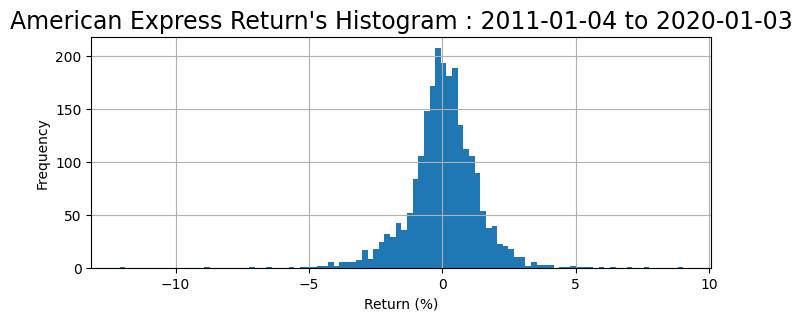

In [8]:
plt.figure(figsize=(8,3))
plt.hist(prices['return'], bins=100)
plt.title(
    'American Express Return\'s Histogram : '+
    min(prices.index).strftime('%Y-%m-%d')+
    ' to '+
    max(prices.index).strftime('%Y-%m-%d'),
    fontsize=17
)
plt.xlabel('Return (%)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [9]:
print('Mean\t\t : ',prices['return'].mean())
print('Variance\t : ',prices['return'].var())
print('Skewness\t : ',prices['return'].skew())
print('Kurtosis\t : ',prices['return'].kurtosis())

Mean		 :  0.05507091359887325
Variance	 :  1.8006052702755442
Skewness	 :  -0.3857569777177754
Kurtosis	 :  7.120513770330035


# Cornish y Fisher

The Cornish and Fisher expansion is, as we can see in this <a href="https://www.riskconcile.com/wp-content/uploads/2020/03/cornish_fisher.html">webpage</a>, <i>"an asymptotic expansion used to approximate the quantiles of a probability distribution based on its moments"</i>. Basically this expansion does allow to get percentiles from non-normal distributions applying a closed form formula, using the first 4 moments, such as: mean, variance, skewness and excess kurtosis.

About C-F anatomy, we can see <a href="https://www.riskconcile.com/wp-content/uploads/2020/03/cornish_fisher_2.html">this</a>, where with:

* $Z_{CF,\alpha}$ the Cornish Fisher Z
* $Z_{\alpha}$ where $Z_{\alpha} \thicksim N(0,1)$
* $S$, the skewness coefficient
* $K$, the excess coefficient

$Z_{CF,\alpha} = Z_{\alpha} + \frac{1}{6}(Z_{\alpha}^2-1)S + \frac{1}{24}(Z_{\alpha}^3-3Z_{\alpha})K - \frac{1}{36}(2Z_{\alpha}^3-5Z_{\alpha})S^2$

In [10]:
def Z_cornish_fisher(Z, S, K):
    try:
        return Z + \
                (1/6)*(Z**2-1)*S+\
                (1/24)*(Z**3-3*Z)*K-\
                (1/36)*(2*Z**3-5*Z)*S**2
    except Exception as exe:
        print('Error Z_cornish_fisher()')
        raise

In this way a semi-parametric method was proposed some years ago, to calculate Value at Risk (VaR). This approach is named as Cornish-Fisher VaR or modified VaR (mVaR). To this is necessary to calculate $VaR_{CF,\alpha}$ as:

$VaR_{CF,\alpha} = \mu + Z_{CF,\alpha} \sigma_{CF}$

where $\sigma_{CF}$, following <a href="https://link.springer.com/article/10.1007%2Fs10479-018-2792-4">(Amédée, C & Barthélémy, F & Maillard, D. 2018)</a> is:

$\sigma_{CF} = \frac{\sigma}{\sqrt{
1+\frac{1}{96}K^2+\frac{25}{1296}S^4-\frac{1}{36}KS^2
}}$

In [11]:
def modified_var(returns, significance_level=0.01):
    try:
        K_CF = returns.kurtosis()
        S_CF = returns.skew()
        Z_CF_v = Z_cornish_fisher(norm.ppf(significance_level),S_CF, K_CF)
        sigma_CF = returns.std()/math.sqrt(1+(1/96)*(K_CF**2)+(25/1296)*(S_CF**4)-(1/36)*K_CF*(S_CF**2))
        VaR_CF = returns.mean() + Z_CF_v*sigma_CF
        return -VaR_CF
    except Exception as exe:
        print('Error modified_var()')
        raise

An important issue in this approach is some authors pointed out a misconception about $S$ and $K$ parameters. Some authors as  <a href='https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1997178'>(Maillard, D. 2018)</a> and <a href="https://link.springer.com/article/10.1007%2Fs10479-018-2792-4">(Amédée, C & Barthélémy, F & Maillard, D. 2018)</a> show this misconception, and express some partial solutions to it. Is necesary recognize this methods are hard to implement because imply solve large equations.

# Results
Choosing the price's return of last year...

In [12]:
prices_h = prices.copy()
prices = prices[-252:]

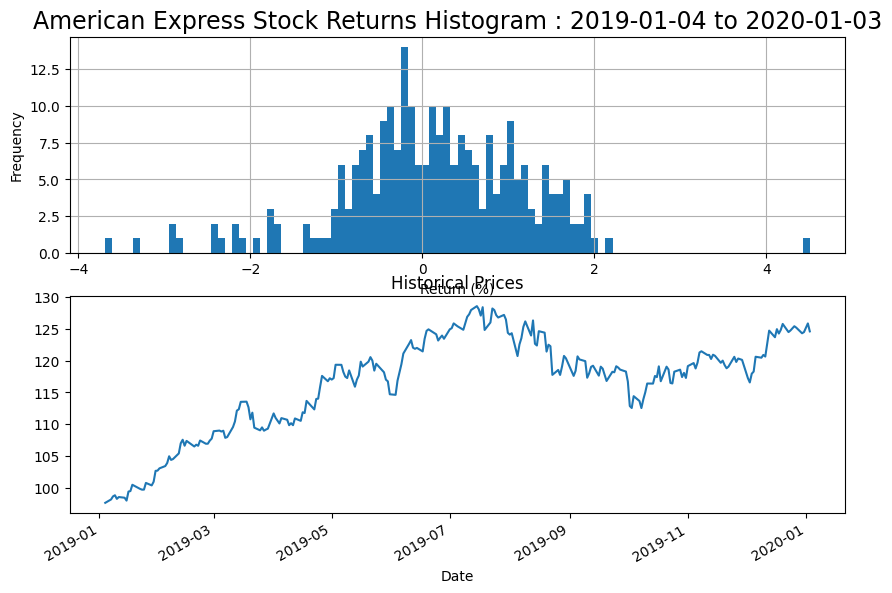

In [13]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
prices['return'].hist(bins=100)
plt.title(
    'American Express Stock Returns Histogram : '+
    min(prices.index).strftime('%Y-%m-%d')+
    ' to '+
    max(prices.index).strftime('%Y-%m-%d'),
    fontsize=17
)
plt.xlabel('Return (%)')
plt.ylabel('Frequency')

plt.subplot(2,1,2)
prices['Price'].plot()
plt.title('Historical Prices')

plt.show()

In [14]:
print('Mean\t\t : ',prices['return'].mean())
print('Variance\t : ',prices['return'].var())
print('Skewness\t : ',prices['return'].skew())
print('Kurtosis\t : ',prices['return'].kurtosis())

Mean		 :  0.12003264411263095
Variance	 :  1.1475046358368959
Skewness	 :  -0.3378830224950175
Kurtosis	 :  1.5935782645973875


In [15]:
VaR_CF_test = pd.DataFrame(columns=['significance_level', 'var_CF'])
for significance_i in np.arange(0.005,0.07,0.005).tolist():
    VaR_CF_test.loc[len(VaR_CF_test)] = [significance_i,modified_var(prices['return'], significance_i)]

In [16]:
VaR_CF_test.head()

,significance_level,var_CF
0,0.005,3.533418
1,0.010,2.958058
2,0.015,2.630015
3,0.020,2.400886
4,0.025,2.225113


# Comparison EVT and Parametric VaR
The EVT and Parametric VaR to AXP was develop in this <a href="https://github.com/craquinterogo/quantitative_finance/blob/master/Risk/Market/VaR/EVT_ExtremeValueTheory.ipynb">link</a>

.. loading that results here ..

In [17]:
results_EVT = pd.read_csv('datasource/results/EVT/evt_results.csv')

In [18]:
results_EVT.rename(columns={'differences':'diff_evt_param'}, inplace=True)

In [19]:
results = results_EVT.merge(
            VaR_CF_test,
            on='significance_level'
            )
del results_EVT

In [20]:
results['diff_cf_param'] = results['var_CF'] - results['var_parametric']
results['diff_cf_evt'] = results['var_CF'] - results['var_evt']

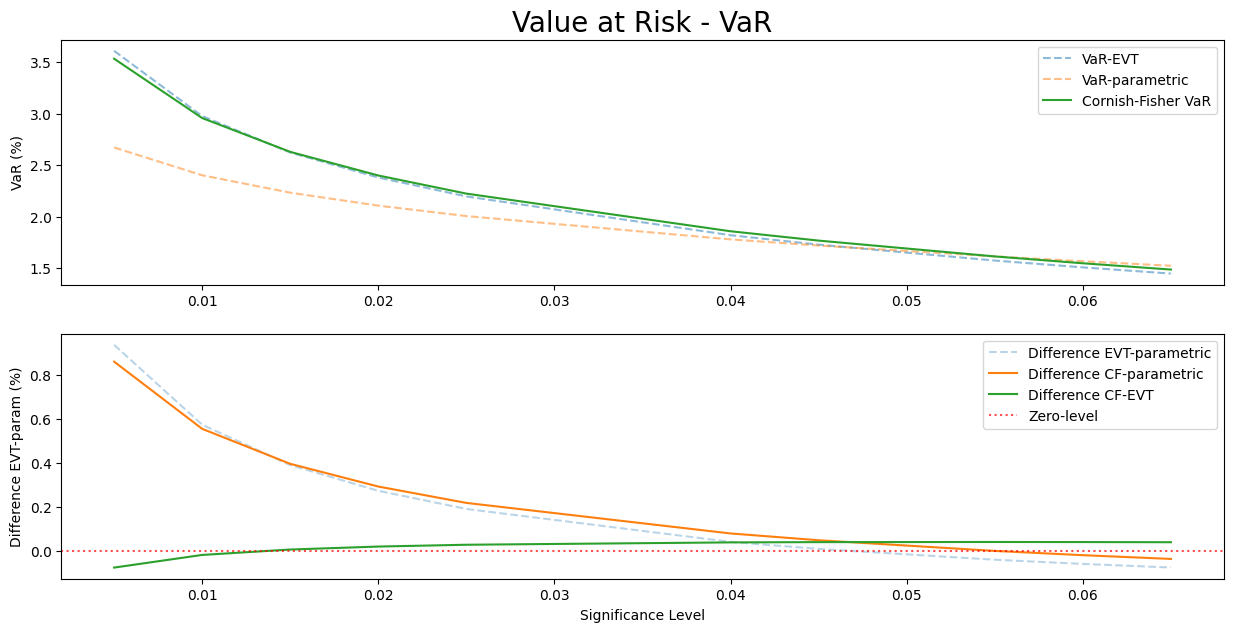

In [21]:
plt.figure(figsize=(15,7))

plt.subplot(2,1,1)
plt.plot(results['significance_level'], results['var_evt'], label='VaR-EVT', linestyle='dashed', alpha=0.5)
plt.plot(results['significance_level'], results['var_parametric'], label='VaR-parametric', linestyle='dashed', alpha=0.5)
plt.plot(results['significance_level'], results['var_CF'], label='Cornish-Fisher VaR')
plt.title('Value at Risk - VaR', fontsize=20)
plt.ylabel('VaR (%)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(results['significance_level'], results['diff_evt_param'], label='Difference EVT-parametric', linestyle='dashed', alpha=0.3)
plt.plot(results['significance_level'], results['diff_cf_param'], label='Difference CF-parametric')
plt.plot(results['significance_level'], results['diff_cf_evt'], label='Difference CF-EVT')
plt.axhline(y=0, color='r', linestyle='dotted', alpha=0.7, label='Zero-level')
plt.ylabel('Difference EVT-param (%)')
plt.xlabel('Significance Level')
plt.legend()

plt.show()

In [22]:
del prices, results, VaR_CF_test

# Cornish-Fisher VaR Backtesting

In backtesting task some test are common as <a href='https://www.springer.com/gp/book/9783658119072' target='blank'>(Roccioletti, S. 2015)</a>:
* <a href='https://www.jstor.org/stable/2527341?seq=1' target='black'>Christoffersen (1998)</a>
* <a href='https://www.systemic-risk-hub.org/papers/bibliography/Kupiec_1995_Preview.pdf' target='blank'>Kupiec (1995)</a>
* <a href='https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1028807' target='blank'>Hendriks (1996)</a>
* <a href='https://www.ime.usp.br/~rvicente/risco/haas.pdf'>Hass (2001)</a>

For test mVaR was used Mixed Kupiec Test, proposed by Hass (2001).

## Kupiec Approach

The VaR definition at $\alpha$ confidence level is:

$P(L > VaR_{\alpha}(L)) = 1 - \alpha$

The violation process can be denoted as:

$I_{t+1} = \mathbb{1}_{\{L(t+1) > VaR_{\alpha}(L(t+1))\}}$

which represents a mark of $1$ if the loses in time $t+1$ is lower than $VaR_\alpha$ calculated to $t+1$, and $0$ in other case. Ought be expect the value $1$ beeing at a probability $1-\alpha$. Will be used 4 significance levels $\alpha = \{5\%, 3\%, 2\%, 1\%\}$

In [23]:
VaR_window = 252
l_significance_levels = [0.05, 0.03, 0.02, 0.01]

In [24]:
for lvl_i in l_significance_levels:
    f_modified_var = partial(modified_var, significance_level=lvl_i)
    tag_analysis = str(int(lvl_i*100))+'p'
    prices_h['mVaR_'+tag_analysis] = -prices_h[['return']].rolling(VaR_window).apply(f_modified_var)
del f_modified_var
prices_mVaR_h = prices_h.copy()
prices_mVaR_h['VaR_window'] = VaR_window

In [25]:
for lvl_i in l_significance_levels:
    significance_level_analysis = lvl_i
    tag_analysis = str(int(significance_level_analysis*100))+'p'
    prices_mVaR_h['I_'+tag_analysis] = (prices_mVaR_h['return'] < prices_mVaR_h['mVaR_'+tag_analysis]) * 1

Values must be shift because the metrics is calculated to the VaR in t, not at $t+Window_{VaR}$

In [26]:
for lvl_i in l_significance_levels:
    significance_level_analysis = lvl_i
    tag_analysis = str(int(significance_level_analysis*100))+'p'
    prices_mVaR_h[['sum_VaR_below_'+tag_analysis]] = prices_mVaR_h[['I_'+tag_analysis]].rolling(VaR_window).sum().shift(-VaR_window)

Taking $\hat{p}$ as  the probability where loss do exceed $mVaR$

$\widetilde{p} = \frac{x}{T}$

where $x$ is times where losses did exceed $mVaR_{\alpha}$ and $T$ the window frame samples

In [27]:
for lvl_i in l_significance_levels:
    significance_level_analysis = lvl_i
    tag_analysis = str(int(significance_level_analysis*100))+'p'
    prices_mVaR_h['p_hat_'+tag_analysis] = prices_mVaR_h['sum_VaR_below_'+tag_analysis] / prices_mVaR_h['VaR_window']

In [28]:
colors_to_plots = {
    0.05 : 'blue',
    0.03 : 'orange',
    0.02 : 'red',
    0.01 : 'green',
}

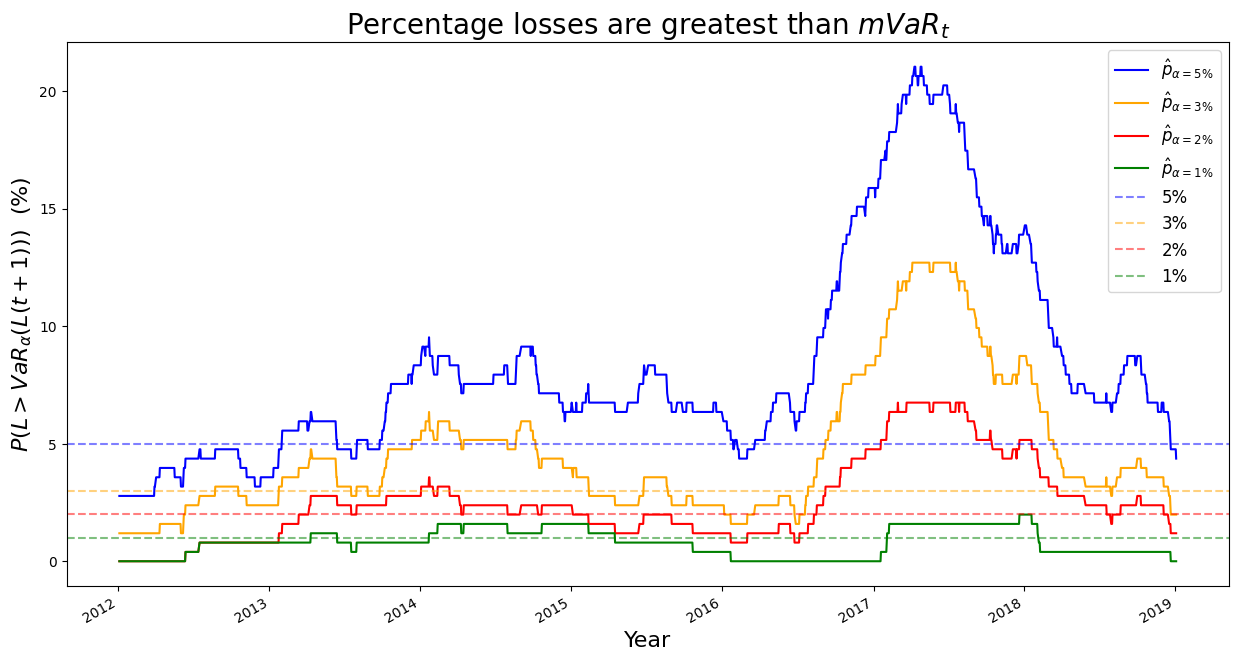

In [29]:
plt.figure(figsize=(15,8))

for lvl_i in l_significance_levels:
    significance_level_analysis = lvl_i
    tag_analysis = str(int(significance_level_analysis*100))+'p'
    (prices_mVaR_h['p_hat_'+tag_analysis][VaR_window:-VaR_window]*100).plot(label='$\hat{p}_{\\alpha='+str(int(significance_level_analysis*100))+'\%}$', c=colors_to_plots[lvl_i])

for lvl_i in l_significance_levels:
    significance_level_analysis = lvl_i
    tag_analysis = str(int(significance_level_analysis*100))+'p'
    plt.axhline(int(significance_level_analysis*100), alpha=0.5, c=colors_to_plots[lvl_i], linestyle='dashed', label=str(int(significance_level_analysis*100))+'%')

plt.title('Percentage losses are greatest than $mVaR_t$', fontsize=20)
plt.ylabel('$P(L>VaR_{\\alpha}(L(t+1)))$  (%)', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.legend(fontsize=12)

plt.show()

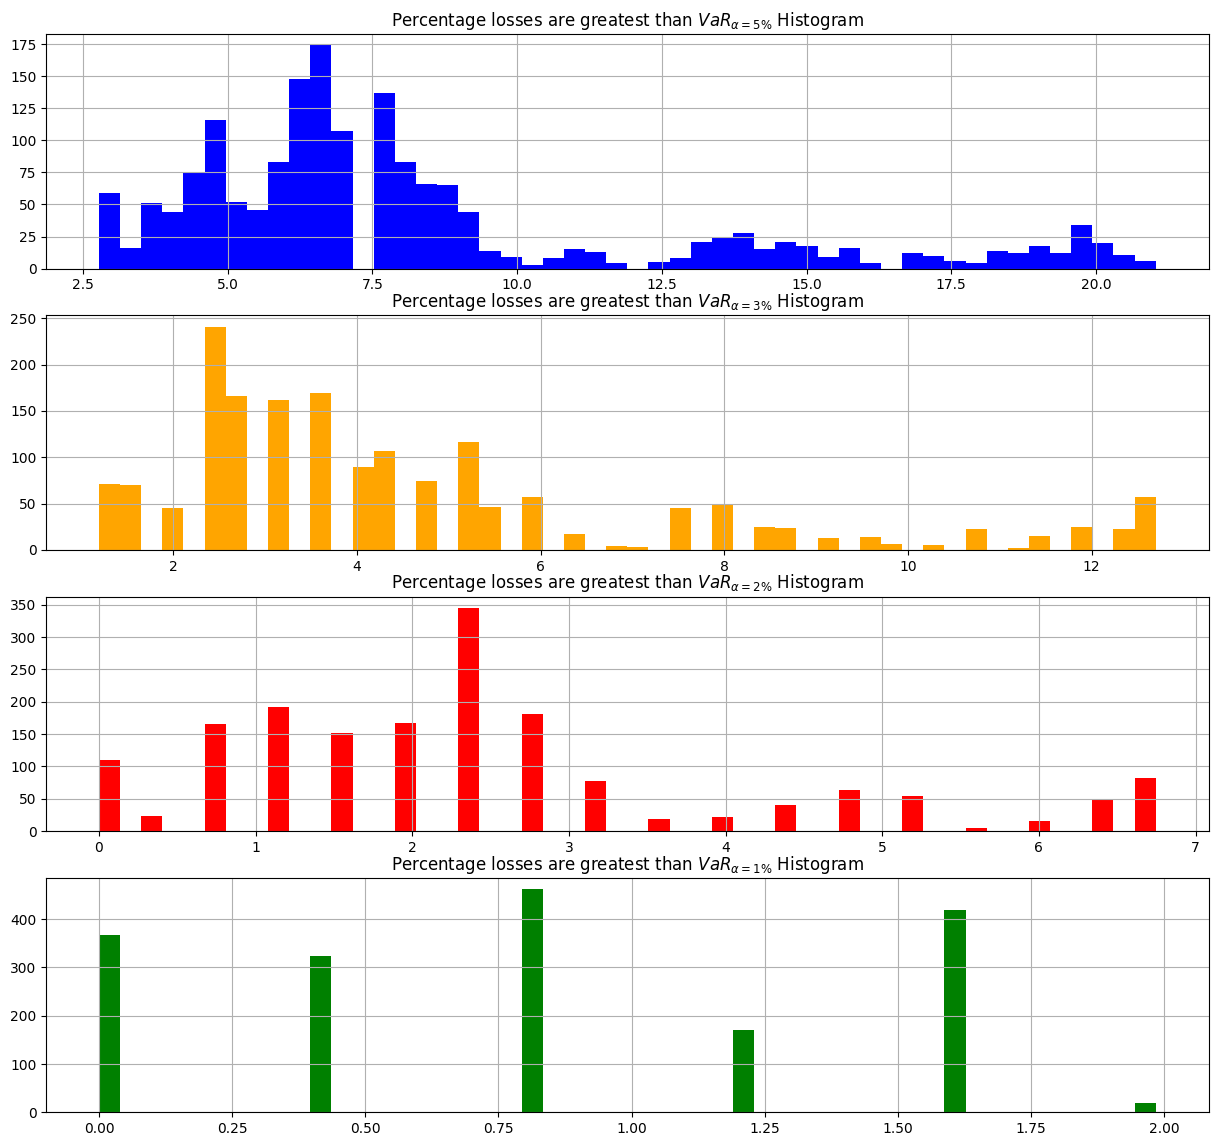

In [30]:
fig, ax = plt.subplots(4,1, figsize=(15,14))

for lvl_it in range(len(l_significance_levels)):
    significance_level_analysis = l_significance_levels[lvl_it]
    tag_analysis = str(int(significance_level_analysis*100))+'p'

    (prices_mVaR_h['p_hat_'+tag_analysis][VaR_window:-VaR_window]*100).hist(bins=50,ax=ax[lvl_it], color=colors_to_plots[significance_level_analysis])
    ax[lvl_it].set_title('Percentage losses are greatest than $VaR_{\\alpha='+str(int(significance_level_analysis*100))+'\%}$ Histogram')
    
plt.show()

## Kupiec Tests

This example following the conditional coverage test behavior, in this sense the test could be constructed as Mixed Kupiec test, see <a href='https://www.springer.com/gp/book/9783658119072' target='blank'>(Roccioletti, S. 2015)</a> and <a href='https://www.ime.usp.br/~rvicente/risco/haas.pdf' target='blank'>(Hass, M. 2001)</a>, having:

In [31]:
significance_level_analysis = 0.01
tag_analysis = str(int(significance_level_analysis*100))+'p'

### Kupiec's POF-Test (Porportion Of Failures)

$LR_{POF} = -2ln\left( \frac{p^x(1-p)^{T-x}}{\widetilde{p}^x\left(1-\widetilde{p}\right)^{T-x}} \right)$
    
remember $\widetilde{p} = \frac{x}{T}$
    
<i>LR is by Likelihood-Ratio-Test</i>

$H_0$ : the model has correct specification

$H_1$ : statistically, there is not data to conclude the model has correct specification

$LR_{POF} \thicksim X_1^2$

if $LR_{POF} < X_1^2 \implies$ The model is accepted in ther way is rejected

In [32]:
def LR_POF(p, p_widetilde, T, x):
    num_ = (p**x)*((1-p)**(T-x))
    den_ = (p_widetilde**x)*((1-p_widetilde)**(T-x))
    LR = -2*np.log(num_/den_)
    return LR

In [33]:
for lvl_i in l_significance_levels:
    significance_level_analysis = lvl_i
    tag_analysis = str(int(significance_level_analysis*100))+'p'
    prices_mVaR_h['LR_POF_'+tag_analysis] = prices_mVaR_h.apply( lambda x : LR_POF(p=significance_level_analysis, p_widetilde=x['p_hat_'+tag_analysis], T=x['VaR_window'], x=x['sum_VaR_below_'+tag_analysis]), axis=1)
    prices_mVaR_h['LR_POF_'+tag_analysis+'_threshold'] = chi2.isf(q=significance_level_analysis,df=1)

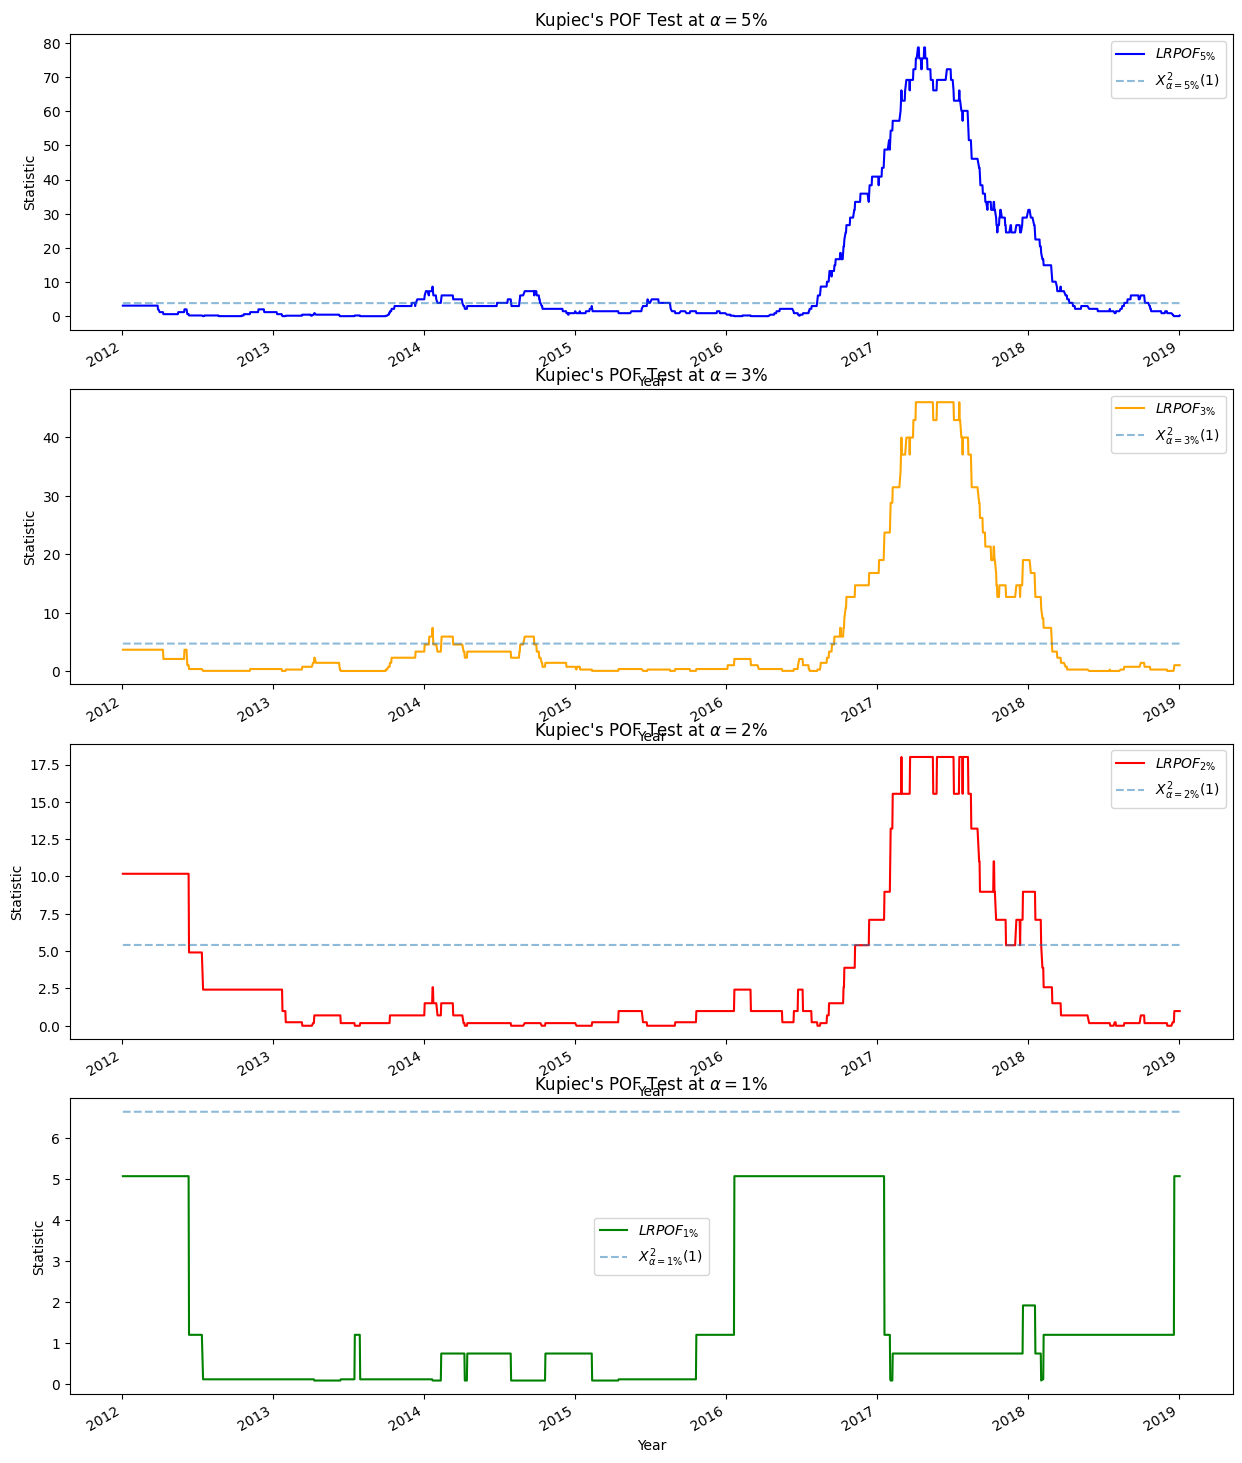

In [34]:
plt.figure(figsize=(15,20))
for lvl_it in range(len(l_significance_levels)):
    significance_level_analysis = l_significance_levels[lvl_it]
    tag_analysis = str(int(significance_level_analysis*100))+'p'
    
    plt.subplot(len(l_significance_levels),1,lvl_it+1)
    prices_mVaR_h['LR_POF_'+tag_analysis][VaR_window:-VaR_window].plot(label='$LRPOF_{'+str(int(significance_level_analysis*100))+'\%}$', c=colors_to_plots[significance_level_analysis])
    prices_mVaR_h['LR_POF_'+tag_analysis+'_threshold'][VaR_window:-VaR_window].plot(label='$X_{\\alpha='+str(int(significance_level_analysis*100))+'\%}^2(1)$', linestyle='dashed', alpha=0.5)
    plt.title('Kupiec\'s POF Test at $\\alpha={s_lvl}$%'.format(s_lvl=int(significance_level_analysis*100)))
    plt.ylabel('Statistic')
    plt.xlabel('Year')
    plt.legend()
plt.show()

### Kupiec's TUFF-Test (Time Until First Failure)

$LR_{TUFF} = -2ln\left( \frac{p(1-p)^{v-1}}{\hat{p}(1-\hat{p})^{v-1}} \right)$

where $p$ is the significance level $\alpha$, $v$ is the time until first exception in sample, and $\hat{p}$ is:

$\hat{p} = \frac{1}{v}$

$H_0$ : the model has correct specification

$H_1$ : statistically, there is not data to conclude the model has correct specification

$LR_{TUFF} \thicksim X_1^2$

if $LR_{TUFF} < X_1^2 \implies$ The model is accepted in ther way is rejected

In [35]:
def time_until_first_failure(serie):
    first_ = serie.cumsum().min()
    tuff = serie[serie <= first_].count()
    return tuff

In [36]:
def LR_TUFF(p, p_hat, v):
    num_ = p*((1-p)**(v-1))
    den_ = p_hat*((1-p_hat)**(v-1))
    LR = -2*np.log(num_/den_)
    return LR

In [37]:
for lvl_i in l_significance_levels:
    significance_level_analysis = lvl_i
    tag_analysis = str(int(significance_level_analysis*100))+'p'
    prices_mVaR_h[['tuff_'+tag_analysis]] = prices_mVaR_h[['I_'+tag_analysis]].rolling(VaR_window).apply(time_until_first_failure)
    prices_mVaR_h['LR_TUFF_'+tag_analysis] = prices_mVaR_h.apply(lambda x : LR_TUFF(p=significance_level_analysis, p_hat=1/x['tuff_'+tag_analysis], v=x['tuff_'+tag_analysis]), axis=1)
    prices_mVaR_h['LR_TUFF_'+tag_analysis+'_threshold'] = chi2.isf(q=significance_level_analysis,df=1)

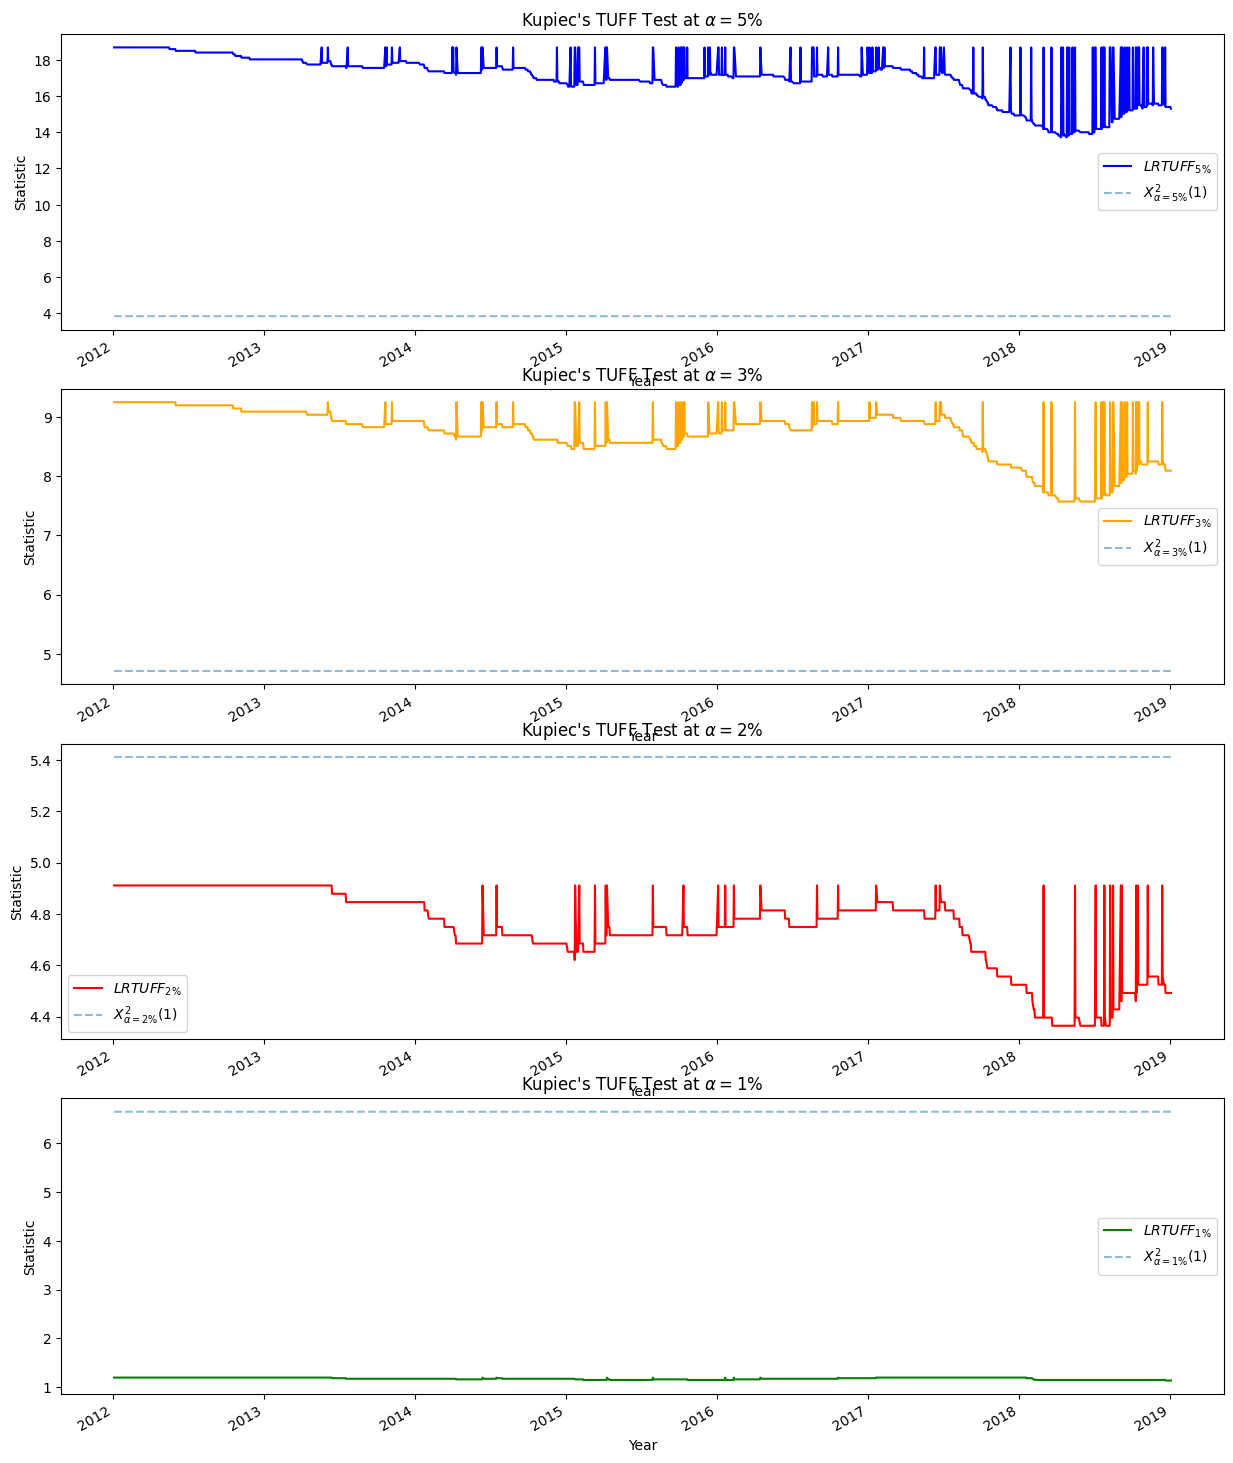

In [38]:
plt.figure(figsize=(15,20))
for lvl_it in range(len(l_significance_levels)):
    significance_level_analysis = l_significance_levels[lvl_it]
    tag_analysis = str(int(significance_level_analysis*100))+'p'
    
    plt.subplot(len(l_significance_levels),1,lvl_it+1)
    prices_mVaR_h['LR_TUFF_'+tag_analysis][VaR_window:-VaR_window].plot(label='$LRTUFF_{'+str(int(significance_level_analysis*100))+'\%}$', c=colors_to_plots[significance_level_analysis])
    prices_mVaR_h['LR_TUFF_'+tag_analysis+'_threshold'][VaR_window:-VaR_window].plot(label='$X_{\\alpha='+str(int(significance_level_analysis*100))+'\%}^2(1)$', linestyle='dashed', alpha=0.5)
    plt.title('Kupiec\'s TUFF Test at $\\alpha={s_lvl}$%'.format(s_lvl=int(significance_level_analysis*100)))
    plt.ylabel('Statistic')
    plt.xlabel('Year')
    plt.legend()
plt.show()

### Mixed Kupitec's Test

This test have three parts to be computed

$LR_i = -2ln\left( \frac{p(1-p)^{v_i-1}}{\hat{p}\left(1-\hat{p}\right)^{v_i-1}} \right)$

remember from $LR_{TUFF}$ that $\hat{p} = \frac{1}{v}$.

$LR_{ind} = \sum_{i=2}^nLR_i + LR_{TUFF}$

$LR_{mix} = LR_{ind}+LR_{POF}$


where $v_i$ is the time between exception $i$ and exception $i-1$

$H_0$ : the model has correct specification

$H_1$ : statistically, there is not data to conclude the model has correct specification

$LR_{mix} \thicksim X_{n+1}^2$

if $LR_{mix} < X_{n+1}^2 \implies$ The model is accepted in ther way is rejected

Solving $\sum_{i=2}^nLR_i$

$LR_i = -2ln\left( \frac{p(1-p)^{v_i-1}}{\hat{p}\left(1-\hat{p}\right)^{v_i-1}} \right)$

$LR_i = -2ln\left( \frac{p}{\hat{p}}\frac{(1-p)^{v_i-1}}{\left(1-\hat{p}\right)^{v_i-1}} \right)$

$LR_i = -2ln\left( \frac{p}{\hat{p}}\left(\frac{1-p}{1-\hat{p}}\right)^{v_i-1} \right)$

$LR_i = -2\left[ln\left( \frac{p}{\hat{p}}\right)+ln\left(\left(\frac{1-p}{1-\hat{p}}\right)^{v_i-1} \right)\right]$

$LR_i = -2\left[ln\left( \frac{p}{\hat{p}}\right)+(v_i-1)ln\left(\frac{1-p}{1-\hat{p}}\right)\right]$

$LR_i = -2ln\left( \frac{p}{\hat{p}}\right)-2(v_i-1)ln\left(\frac{1-p}{1-\hat{p}}\right)$

Then ...

$\sum_{i=2}^nLR_i = \sum_{i=2}^n\left[-2ln\left( \frac{p}{\hat{p}}\right)-2(v_i-1)ln\left(\frac{1-p}{1-\hat{p}}\right)\right]$

$\sum_{i=2}^nLR_i = \sum_{i=2}^n\left[-2ln\left( \frac{p}{\hat{p}}\right)\right]-\sum_{i=2}^n\left[2(v_i-1)ln\left(\frac{1-p}{1-\hat{p}}\right)\right]$

$\sum_{i=2}^nLR_i = -2(n-1)ln\left( \frac{p}{\hat{p}}\right)-2ln\left(\frac{1-p}{1-\hat{p}}\right)\sum_{i=2}^n\left[(v_i-1)\right]$

Taking $D_i = \sum_{i=2}^n\left[(v_i-1)\right]$

$\sum_{i=2}^nLR_i = -2(n-1)ln\left( \frac{p}{\hat{p}}\right)-2ln\left(\frac{1-p}{1-\hat{p}}\right)D_i$

In this way ...

$LR_{ind} = -2(n-1)ln\left( \frac{p}{\hat{p}}\right)-2ln\left(\frac{1-p}{1-\hat{p}}\right)D_i + LR_{TUFF}$

In [39]:
def calculate_Di(serie):
    c_ = serie.cumsum()
    if c_[c_>2].count() == 0:
        return 0
    else:
        c_ = c_.value_counts()
        c_ = c_ - 1
        return np.sum(c_)

def calculate_number_exceptions(serie):
    c_ = serie.cumsum()
    c_ = c_[c_>0]
    if c_.count() > 0:
        c_ = c_.value_counts()
        return c_.count()
    else:
        return 0

def LR_ind(p, p_hat, Di , LR_tuff, number_of_exceptions):
    LR = -2*(number_of_exceptions-1)*np.log(p/p_hat)-2*np.log((1-p)/(1-p_hat))*Di+LR_tuff
    return LR

In [40]:
for lvl_i in l_significance_levels:
    significance_level_analysis = lvl_i
    tag_analysis = str(int(significance_level_analysis*100))+'p'

    prices_mVaR_h[['Di_'+tag_analysis]] = prices_mVaR_h[['I_'+tag_analysis]].rolling(VaR_window).apply(calculate_Di)
    prices_mVaR_h[['Di_n_'+tag_analysis]] = prices_mVaR_h[['I_'+tag_analysis]].rolling(VaR_window).apply(calculate_number_exceptions)

    prices_mVaR_h['LR_ind_'+tag_analysis] = prices_mVaR_h.apply(lambda x: LR_ind(p=significance_level_analysis, p_hat=1/x['tuff_'+tag_analysis], Di=x['Di_'+tag_analysis], LR_tuff=x['LR_TUFF_'+tag_analysis], number_of_exceptions=x[['Di_n_'+tag_analysis]]), axis=1)

    prices_mVaR_h['LR_MIX_'+tag_analysis] = prices_mVaR_h['LR_ind_'+tag_analysis] + prices_mVaR_h['LR_POF_'+tag_analysis]
    prices_mVaR_h['LR_MIX_'+tag_analysis+'_threshold'] = chi2.isf(q=significance_level_analysis,df=prices_mVaR_h['Di_n_'+tag_analysis]+1)

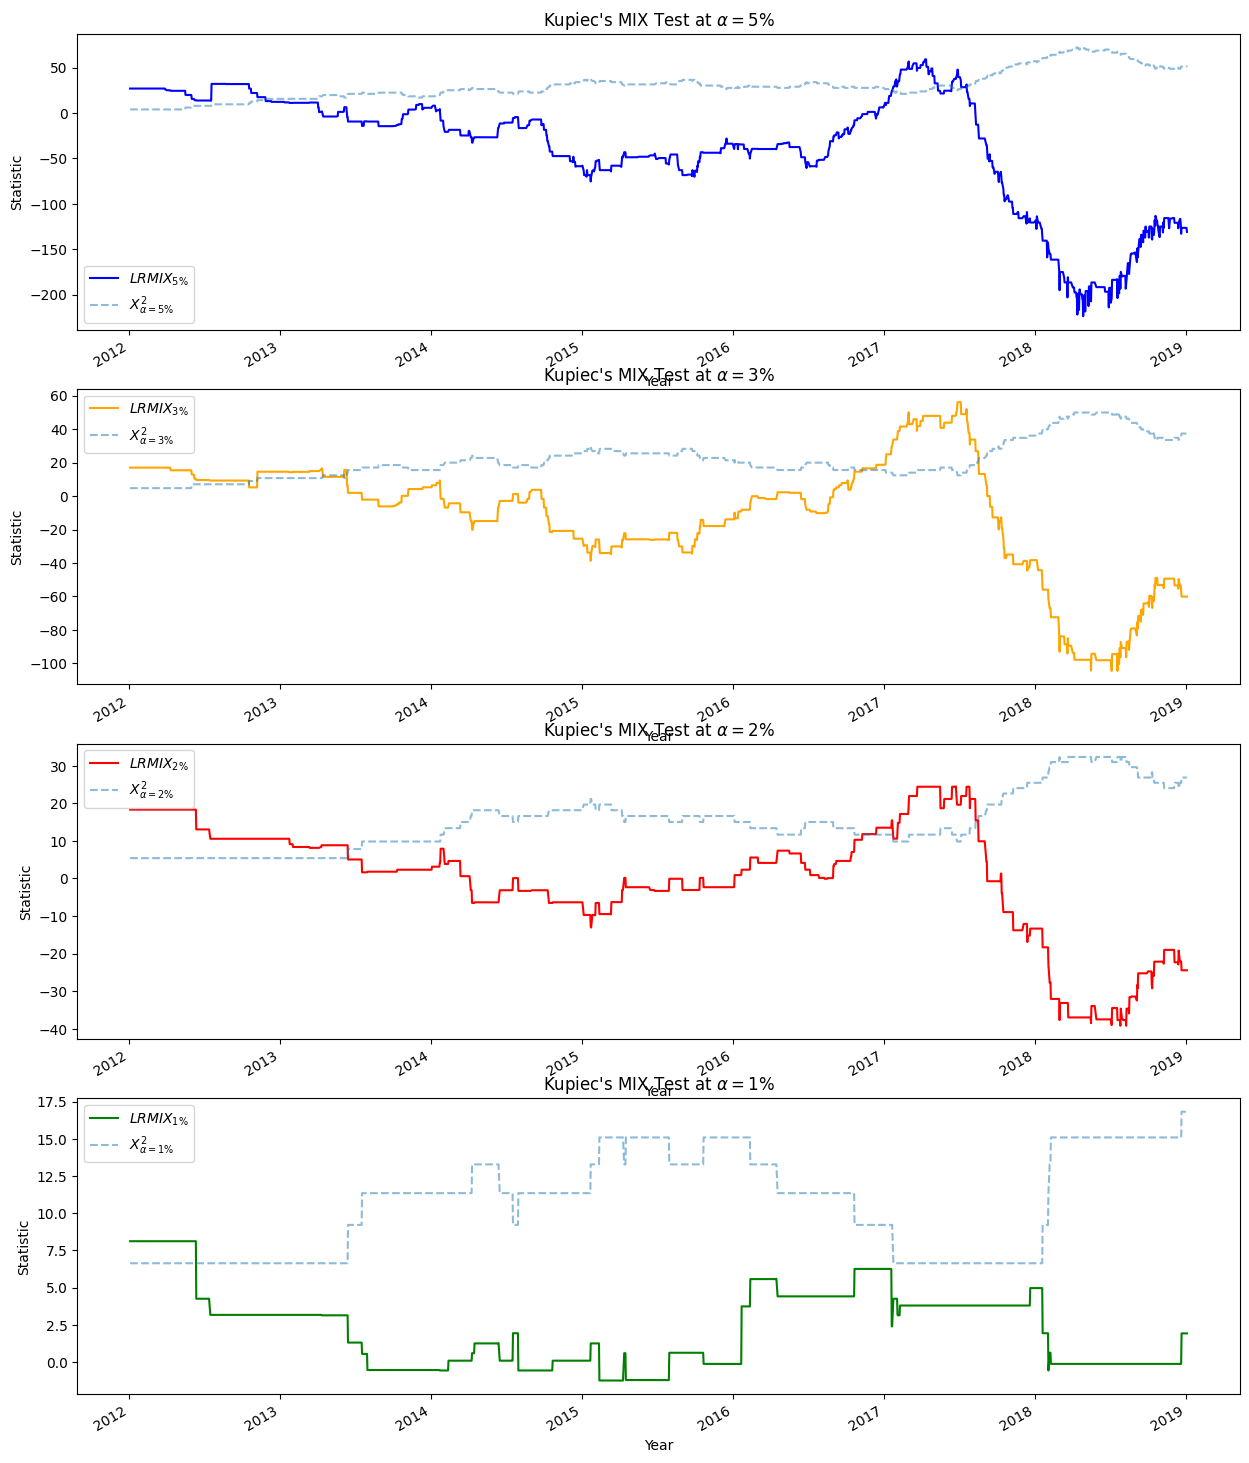

In [41]:
plt.figure(figsize=(15,20))
for lvl_it in range(len(l_significance_levels)):
    significance_level_analysis = l_significance_levels[lvl_it]
    tag_analysis = str(int(significance_level_analysis*100))+'p'
    
    plt.subplot(len(l_significance_levels),1,lvl_it+1)
    prices_mVaR_h['LR_MIX_'+tag_analysis][VaR_window:-VaR_window].plot(label='$LRMIX_{'+str(int(significance_level_analysis*100))+'\%}$', c=colors_to_plots[significance_level_analysis])
    prices_mVaR_h['LR_MIX_'+tag_analysis+'_threshold'][VaR_window:-VaR_window].plot(label='$X_{\\alpha='+str(int(significance_level_analysis*100))+'\%}^2$', linestyle='dashed', alpha=0.5)
    plt.title('Kupiec\'s MIX Test at $\\alpha={s_lvl}$%'.format(s_lvl=int(significance_level_analysis*100)))
    plt.ylabel('Statistic')
    plt.xlabel('Year')
    plt.legend()
plt.show()

# Limitations

The approximation accuracy is determined by the nearest distribution to the normal distribution. In this way, the nearest must be in skewness and excesss kurtosis. Beside this, increase the CF order will not improve the approximation accuracy. see <a href="https://www.jstor.org/stable/2347649?seq=1">Lee, Y & Lin, T. (1992)</a> and <a href="https://core.ac.uk/download/pdf/77052435.pdf">Lamb, J. & Monville, M. & Tee, K. (2016) </a>

A very important issue about the Cornish-Fisher formula, is $S$ and $K$ are not the actual skewness and excess kurtosis, or observed. This parameters must be calculated. In this way, some authos like <a href='https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1997178'>(Maillard, D. 2018)</a> and <a href="https://link.springer.com/article/10.1007%2Fs10479-018-2792-4">(Amédée, C & Barthélémy, F & Maillard, D. 2018)</a> did show some values, the first one, and a method, the second one, in their articles.

In Amédée, et. al (2018) article, they resolved the $S$ and $K$ coefficient following the RSM (Response Surface Methodology), given as result this:

$
K = −5.963 + 21.52S_o^{\frac{1}{2}} − 1.548 K_o^{\frac{1}{2}} − 26.52 S_o + 1.820 K_o + 11.08 S_o^{\frac{3}{2}} − 0.442 K_o^{\frac{3}{2}}\\
\hspace{1cm}− 2.564 S_o^{\frac{1}{2}} K_o + 5.740 S_o K_o^{\frac{1}{2}} + 0.342 S_o^2 + 0.0016 K_o^2 + 0.880 S_o K_o\\
\hspace{1cm}− 3.773 S_o^{\frac{3}{2}} K_o^{\frac{1}{2}} + 0.033 S_o^{\frac{1}{2}} K_o^{\frac{3}{2}} + 0.001 S_o K_o^2 + 0.072 S_o^2 K_o − 0.021 S_o^{\frac{3}{2}} K_o^{\frac{3}{2}}\\
\hspace{1cm}− 0.721 ln(S_o) ln(K_o) + 0.349 ln(S_o) K_o + 0.366 S_o ln(K_o) + 0.366 S_o^{-1} − 0.555 K_o^{-1}\\
$

$
S = −1.816 + 6.812 S_o^{\frac{1}{2}} − 0.577K_o^{\frac{1}{2}} − 8.635S_o + 0.508K_o + 4.235S_o^{\frac{3}{2}} − 0.007K_o^{\frac{3}{2}}\\
\hspace{1cm}− 0.848S_o^{\frac{1}{2}}K_o + 2.671S_oK_o^{\frac{1}{2}} − 0.097S_o^2 − 0.0003K_o^2 + 0.225 S_oK_o\\
\hspace{1cm}− 1.258S_o^{\frac{3}{2}}K_o^{\frac{1}{2}} + 0.019 S_o^{\frac{1}{2}}K_o^{\frac{3}{2}} + 0.0002S_oK_o^2 + 0.025S_o^2K_o − 0.0067 S_o^{\frac{3}{2}}K_o^{\frac{3}{2}}\\
\hspace{1cm}− 0.105ln(S_o) ln(K_o) + 0.098 ln(S_o)K_o − 0.845S_oln(K_o) + 0.134S_o^{-1} − 0.416 K_o^{-1}
$

With $S_o$ and $K_o$ as skewness and excess return observed.

In [42]:
S_o = prices_h[-252:]['return'].skew() * np.sign(prices_h[-252:]['return'].skew())
K_o = prices_h[-252:]['return'].kurtosis()

coeffs = np.array([
    1, math.sqrt(S_o), math.sqrt(K_o), S_o, K_o, S_o**(3/2), K_o**(3/2), math.sqrt(S_o)*K_o,
    math.sqrt(K_o)*S_o, S_o**2, K_o**2, S_o*K_o, (S_o**(3/2))*math.sqrt(K_o), (K_o**(3/2))*math.sqrt(S_o),
    S_o*(K_o**2), (S_o**2)*K_o,(S_o**(3/2))*(K_o**(3/2)),math.log(S_o)*math.log(K_o),
    math.log(S_o)*K_o, S_o*math.log(K_o), 1/S_o, 1/K_o
])

K_coeff = np.array([
    -5.963, 21.52, -1.548, -26.52, 1.820, 11.08, -0.442, -2.564,
    5.740, 0.342, 0.0016,0.880, -3.773, 0.033, 0.001, 0.072,
    -0.021,-0.721, 0.349, 0.366, 0.366, -0.555
])

S_coeff = np.array([
    -1.816, 6.812, -0.577, -8.635, 0.508, 4.235, -0.007,
    -0.848, 2.671, -0.097, -0.0003, 0.225,-1.258, 0.019,
    0.0002, 0.025, -0.0067,-0.105, 0.098, -0.845, 0.134, -0.416
])

K_CF = K_coeff @ coeffs.T
S_CF = S_coeff @ coeffs.T

print(K_CF)
print(S_CF)

0.07120202767692507
0.18647185794228632


Some interesting thing is if its compared the results provides by both Amédée, et al. and Maillard, the results are different to $S$ and $K$ parameters. With Amédée method, The result got is $K=-4.51$ and $S=0.23$. With Maillard table to $K_{observed}=7.12$ and $S_{observed}=-0.38$ then $S=0.234$ and $K=2.796$. Both results are clarely different but is importante recognize Maillad's results are most closed to observed parameters.

# Conclusion

Modified VaR (mVaR), or Cornish-Fisher VaR, is a method which can help us to mitigate the strongest assumptions in parametric VaR, including skewness and kurtosis to its formula. But this method seems to have problems with some significance levels. In this way the method is shown as good method when the significance level is lower than $1\%$, in the other hand looks as it is not enough to take into account in the value at risk metric. This was observed in Kupec's POF test, Kupec's TUFF test and Kupec's MIX test, all of them showing the same idea in levels higher than $1\%$. The first two tests do have an static test in the way $X^2$ distribution have an stativ freedom degree, as 1. The third method do not have the static behavior which first two, and that is a reason why we reject the posibility the model was a good method.

One thing is very importante to conclude this, and it is in this test we use the sample skewness and kurtosis, and was not taken into account the issue pointer out by Maillar and Amédée, et al.

One task to probe is choose other asset, and replay the test, but seeking that other asset do has other distribution, different to current asset in the test.

# Bibliography

* <b>Amédée, C & Barthélémy, F & Maillard, D. (2018)</b>Computation of the corrected Cornish–Fisher expansion using the response surface methodology: application to VaR and CVaR
* <b>Hass, M (2001)</b>, New methods in backtesting
* <b>Izhar, H. (2015)</b>, Applying the Cornish-Fisher expansion to value-at-risk estimation in Islamic banking
* <b>Maillard, D (2018)</b>, A user's guide to the Cornish Fisher Expansion
* <b>Risk Concile (2016)</b>, Anatomy of Cornish-Fisher
* <b>Roccioletti, S (2015)</b>, Backtesting value at risk and expected shortfall

<hr/>

This could not to be the final version, so if you have some recommendation or comment about this, I will be grateful to hear it, using e-mail <b>craquinterogo@unal.edu.co</b> or <b>cristian.quintero@est.uexternado.edu.co</b>